The code in this repository is largely based on the work of Olga Ratushniak and Svitlana Myroshnychenko during their MSc thesis. For more information, please contact Beatriz Cabrero-Daniel.

Some imports:

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import os
import pandas as pd
import zCurve as z

Please configure here how many bins should the Generic-CSP (G-CSP) have and what is the threshold for adding a bar in a CSP (barcode) to the G-CSP:

In [34]:
nbins = 20 # more bins = thinner bars
barthreshold = 5 # higher threshold = fewer bars

figsize = (7, 3) 

Creating some fake CSPs to illustrate the CSP (barcode) clustering mechanism. Feel free to play around with the signals.

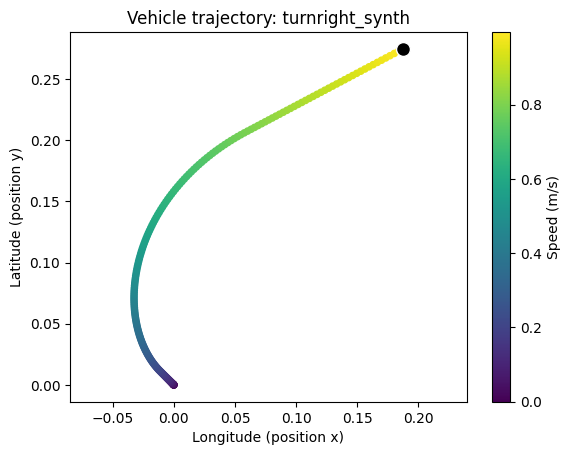

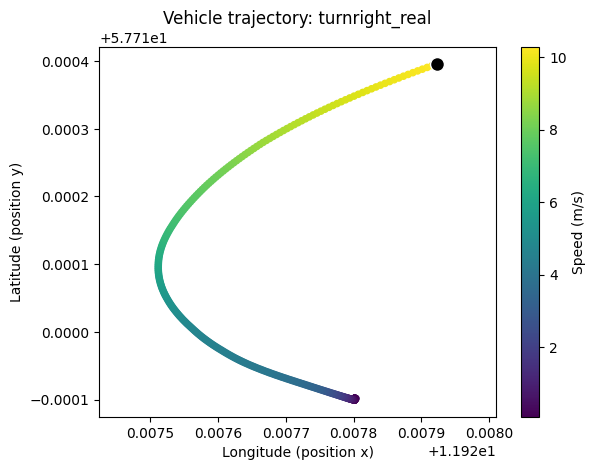

In [35]:
listofcsps = []

folder_path = "results/example_trajectories"
files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
files.sort()
files.reverse()

# ===============================
# DATA FILE PROCESSING
# ===============================
for file_path in files:
    if "turnright" not in file_path:
        continue
    
    file_basename = os.path.splitext(os.path.basename(file_path))[0]
    data = pd.read_csv(file_path, sep=';')    
    data['timestamp'] = data['sampleTimeStamp.seconds'] * 1_000_000 + data['sampleTimeStamp.microseconds']
    
    accel_x = (data["accel_x"] + 10) * 100.0
    accel_y = (data["accel_y"] + 10) * 100.0
    
    # ===============================
    # Plot 1: Vehicle Position Colored by Speed
    # ===============================    
    plt.figure()
    plt.scatter(data['x'], data['y'], c=data['speed'], cmap='viridis', s=20)
    plt.colorbar(label="Speed (m/s)")
    plt.scatter(data.iloc[-1]['x'], data.iloc[-1]['y'], s=100, color="black", edgecolors="white")
    plt.xlabel("Longitude (position x)")
    plt.ylabel("Latitude (position y)")
    plt.title(f"Vehicle trajectory: {file_basename}")
    plt.axis('equal')
    # plot1_filename = os.path.join(output_dir, f"{file_basename}_position.png")
    # plt.savefig(plot1_filename, bbox_inches="tight")
    plt.show()
    plt.close()

    listofcsps +=  [[z.interlace(int(x), int(y), bits_per_dim=13) for x, y in zip(accel_x, accel_y)]]

Configuration settings for the figures created below (you can ignore this):

In [36]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(1/(len(listofcsps)-1)*i) for i in range(len(listofcsps))]
decforyaxis = StrMethodFormatter('{x:,.1f}')
allmortonindices = []
for csp in listofcsps:
    allmortonindices += csp
mortonindexmin = min(allmortonindices)
mortonindexmax = max(allmortonindices)
totalrange = mortonindexmax - mortonindexmin
margins = totalrange/50.0
numsignals = len(listofcsps)

Plotting the generated CSPs together:

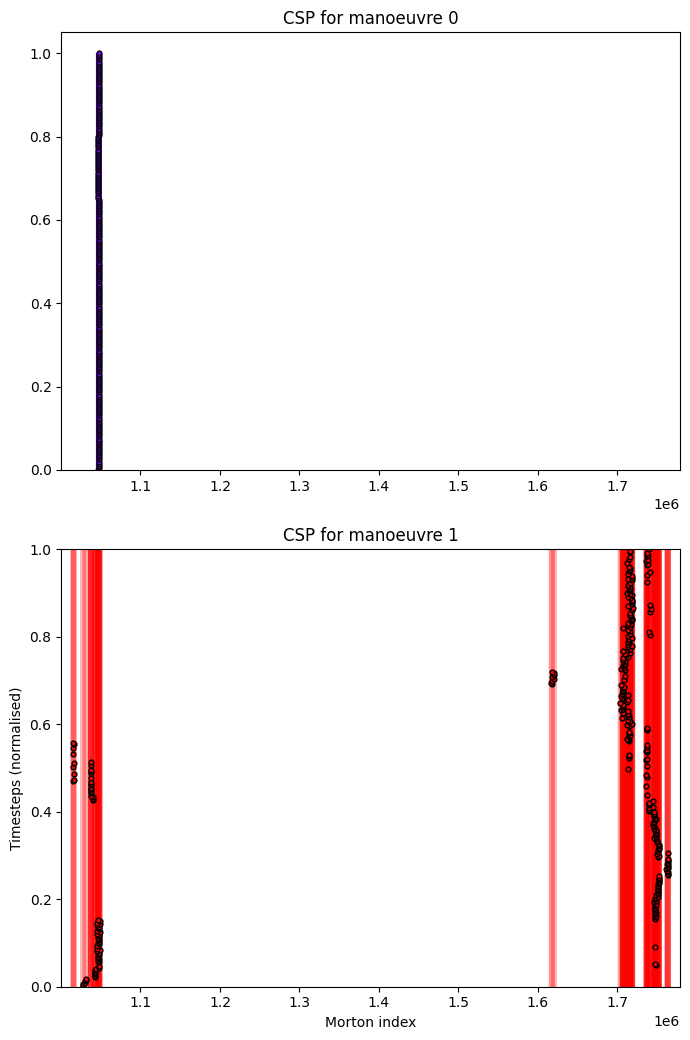

In [37]:
f, sp = plt.subplots(figsize=(7, 6), nrows = numsignals, ncols = 1)
for i, csp in enumerate(listofcsps):
    ranges = [x/(len(csp)-1) for x in range(len(csp))]
    sp[i].bar(csp, [1 for _ in range(len(csp))], width=totalrange/100, color=colors[i], alpha=0.1)
for i, csp in enumerate(listofcsps):
    ranges = [x / (len(csp) - 1) for x in range(len(csp))]
    sp[i].scatter(csp, ranges, color=colors[i], edgecolor="k", s=12)
    sp[i].set_title("CSP for manoeuvre "+str(i))
    sp[i].set_xlim(mortonindexmin-margins, mortonindexmax+margins)
sp[numsignals//2].set_ylabel("Timesteps (normalised)")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(decforyaxis)
plt.xlabel("Morton index")
plt.xlim(mortonindexmin-margins, mortonindexmax+margins)
plt.tight_layout(rect=[0, 0, 1, 1.75])
plt.savefig("results/generic_csps/1csps.png")
plt.show()
plt.close()

Count bars in CSPs (barcodes) in each bin (same width):

In [38]:
bincounter = [0]*nbins
for m in allmortonindices:
    assigned = False
    for bin in range(nbins):
        binmin = mortonindexmin + totalrange/nbins*bin
        binmax = binmin + totalrange/nbins
        if binmin <= m < binmax:
            bincounter[bin] += 1
            assigned = True
    if not assigned:
        bincounter[-1] += 1

Draw the histogram for the bars in the CSPs (aggregated):

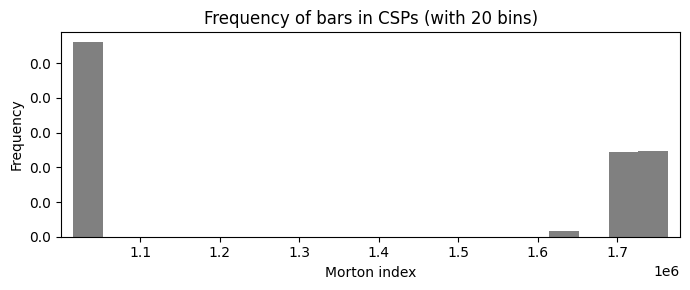

In [39]:
plt.figure(figsize=figsize)
plt.hist(allmortonindices, density=True, color="gray", bins=nbins)
plt.ylabel("Frequency")
plt.gca().yaxis.set_major_formatter(decforyaxis)
plt.xlabel("Morton index")
plt.xlim(mortonindexmin-margins, mortonindexmax+margins)
plt.title("Frequency of bars in CSPs (with "+str(nbins)+" bins)")
plt.tight_layout()
plt.savefig("results/generic_csps/2barfreq_nbins"+str(nbins)+".png")
plt.show()
plt.close()

Draw the generated G-CSP based on the frequency (the amount of bars in each of the bins):

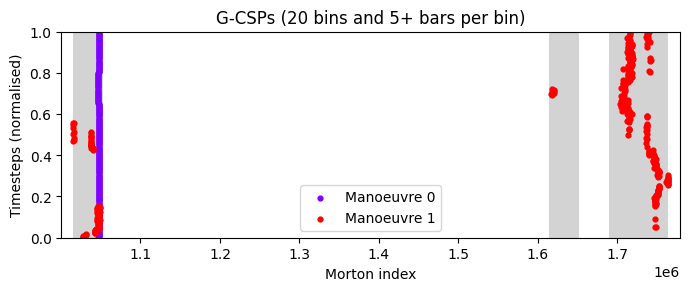

In [40]:
plt.figure(figsize=figsize)
plt.bar([totalrange/nbins/2+mortonindexmin+totalrange/(nbins)*x for x in range(nbins)], [1 if b > barthreshold else 0 for b in bincounter], width=totalrange/nbins, color="lightgray")
for i, csp in enumerate(listofcsps):
    ranges = [x / (len(csp) - 1) for x in range(len(csp))]
    plt.scatter(csp, ranges, color=colors[i], s=12, label="Manoeuvre "+str(i))
plt.ylabel("Timesteps (normalised)")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(decforyaxis)
plt.xlabel("Morton index")
plt.xlim(mortonindexmin-margins, mortonindexmax+margins)
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.title("G-CSPs ("+str(nbins)+" bins and " + str(barthreshold)+"+ bars per bin)")
plt.savefig("results/generic_csps/3gcsps_nbins"+str(nbins)+".png")
plt.show()
plt.close()